## Import Libaries

In [ ]:
!pip install opendatasets
!pip install pandas

you can use my kaggle credentials:

nomielagarde

d8e0f8ad13e663040a0d037b2208f1b6

In [ ]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/nomielagarde/huron-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nomielagarde
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nomielagarde/huron-dataset


100%|██████████| 3.35G/3.35G [02:59<00:00, 20.1MB/s]


In [ ]:
#installing smp libraru
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=90ebcad7e05dd0df7cf8f00de92b72ed15a1c159a2adbfb0cfcb31694496e90e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=3bf5321bf7e431a9a1c46bc4509d752e1d07e66eb9fdd748f169814adbff3d13
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

## Classes and methods

### Dataset

In [ ]:
class HuronDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.image_dir / self.images[idx]
        mask_path = self.mask_dir / self.images[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
        mask = self.mask_transform(mask)

        # Ensure mask is binary
        mask = (mask > 0.5).float()

        return image, mask


### Metrics

In [ ]:
def calculate_iou(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float()
    targets = targets.float()

    intersection = (outputs * targets).sum(dim=(1, 2))
    union = outputs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            iou = calculate_iou(outputs, masks)

            total_loss += loss.item()
            total_iou += iou.item()

    return total_loss / num_batches, total_iou / num_batches

### Visualize results

In [ ]:
def visualize_results(model, test_loader, device, num_images=3):
    model.eval()

    # Get some test images
    test_images, test_masks = next(iter(test_loader))

    with torch.no_grad():
        test_images = test_images.to(device)
        predictions = model(test_images)
        predictions = (predictions > 0.5).float()

    # Convert tensors to numpy for visualization
    test_images = test_images.cpu()
    test_masks = test_masks.cpu()
    predictions = predictions.cpu()

    # Plot results
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))

    for idx in range(num_images):
        # Original image
        img = test_images[idx].permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        img = np.clip(img, 0, 1)

        # Ground truth mask
        mask = test_masks[idx].squeeze().numpy()

        # Predicted mask
        pred = predictions[idx].squeeze().numpy()

        # Plot
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title('Ground Truth Mask')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(pred, cmap='gray')
        axes[idx, 2].set_title('Predicted Mask')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

class CombinedLoss(nn.Module):
    def __init__(self, loss1, loss2, weight1=1.0, weight2=1.0):
        super(CombinedLoss, self).__init__()
        self.loss1 = loss1
        self.loss2 = loss2
        self.weight1 = weight1
        self.weight2 = weight2

    def forward(self, y_pred, y_true):
        return self.weight1 * self.loss1(y_pred, y_true) + self.weight2 * self.loss2(y_pred, y_true)

## Training function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=3):
    best_val_iou = 0

    # Lists to store metrics
    train_losses = []
    train_ious = []
    val_ious = []
    epochs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                iou = calculate_iou(outputs, masks)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                running_iou += iou.item()

                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'IoU': running_iou / (pbar.n + 1)
                })

        # Store epoch metrics
        epochs.append(epoch + 1)
        train_losses.append(running_loss / len(train_loader))
        train_ious.append(running_iou / len(train_loader))

        # Validate
        model.eval()
        val_iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                val_iou += calculate_iou(outputs, masks).item()

        val_iou /= len(val_loader)
        val_ious.append(val_iou)
        print(f'Validation IoU: {val_iou:.4f}')

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')

    # Plot the metrics
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_ious, 'b-', label='Training IoU')
    plt.plot(epochs, val_ious, 'r-', label='Validation IoU')
    plt.title('IoU vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, train_ious, val_ious

## Final Traing and Results

Using device: cuda
Dataset splits: Train=12142, Val=2602, Test=2603
Model: U-Net++ with efficientnet-b4 encoder and AdamW Optimizer


Epoch 1/100: 100%|██████████| 759/759 [01:53<00:00,  6.70it/s, loss=0.361, IoU=0.873]


Validation IoU: 0.9111


Epoch 2/100: 100%|██████████| 759/759 [01:53<00:00,  6.70it/s, loss=0.169, IoU=0.91]


Validation IoU: 0.9141


Epoch 3/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.144, IoU=0.912]


Validation IoU: 0.9130


Epoch 4/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.13, IoU=0.916]


Validation IoU: 0.9131


Epoch 5/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.125, IoU=0.917]


Validation IoU: 0.9173


Epoch 6/100: 100%|██████████| 759/759 [01:53<00:00,  6.70it/s, loss=0.116, IoU=0.92]


Validation IoU: 0.9174


Epoch 7/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.112, IoU=0.921]


Validation IoU: 0.9192


Epoch 8/100: 100%|██████████| 759/759 [01:53<00:00,  6.70it/s, loss=0.109, IoU=0.923]


Validation IoU: 0.9211


Epoch 9/100: 100%|██████████| 759/759 [01:53<00:00,  6.70it/s, loss=0.107, IoU=0.924]


Validation IoU: 0.9205


Epoch 10/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.109, IoU=0.924]


Validation IoU: 0.9194


Epoch 11/100: 100%|██████████| 759/759 [01:53<00:00,  6.71it/s, loss=0.109, IoU=0.923]


Validation IoU: 0.9194


Epoch 12/100: 100%|██████████| 759/759 [01:53<00:00,  6.70it/s, loss=0.105, IoU=0.925]


Validation IoU: 0.9219


Epoch 13/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.103, IoU=0.927]


Validation IoU: 0.9202


Epoch 14/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.099, IoU=0.928]


Validation IoU: 0.9234


Epoch 15/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0986, IoU=0.929]


Validation IoU: 0.9197


Epoch 16/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0963, IoU=0.93]


Validation IoU: 0.9246


Epoch 17/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0952, IoU=0.931]


Validation IoU: 0.9211


Epoch 18/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0919, IoU=0.933]


Validation IoU: 0.9261


Epoch 19/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0927, IoU=0.933]


Validation IoU: 0.9247


Epoch 20/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0923, IoU=0.933]


Validation IoU: 0.9254


Epoch 21/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0919, IoU=0.934]


Validation IoU: 0.9260


Epoch 22/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0904, IoU=0.935]


Validation IoU: 0.9265


Epoch 23/100: 100%|██████████| 759/759 [01:54<00:00,  6.66it/s, loss=0.0877, IoU=0.936]


Validation IoU: 0.9256


Epoch 24/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0856, IoU=0.937]


Validation IoU: 0.9259


Epoch 25/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0842, IoU=0.938]


Validation IoU: 0.9259


Epoch 26/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0845, IoU=0.938]


Validation IoU: 0.9273


Epoch 27/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0868, IoU=0.937]


Validation IoU: 0.9265


Epoch 28/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0843, IoU=0.939]


Validation IoU: 0.9239


Epoch 29/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0828, IoU=0.94]


Validation IoU: 0.9254


Epoch 30/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0813, IoU=0.94]


Validation IoU: 0.9285


Epoch 31/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.08, IoU=0.941]


Validation IoU: 0.9283


Epoch 32/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0797, IoU=0.942]


Validation IoU: 0.9294


Epoch 33/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.078, IoU=0.943]


Validation IoU: 0.9287


Epoch 34/100: 100%|██████████| 759/759 [01:54<00:00,  6.64it/s, loss=0.077, IoU=0.943]


Validation IoU: 0.9305


Epoch 35/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0766, IoU=0.944]


Validation IoU: 0.9285


Epoch 36/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0766, IoU=0.944]


Validation IoU: 0.9285


Epoch 37/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0759, IoU=0.944]


Validation IoU: 0.9285


Epoch 38/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0771, IoU=0.944]


Validation IoU: 0.9286


Epoch 39/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0744, IoU=0.945]


Validation IoU: 0.9300


Epoch 40/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0735, IoU=0.946]


Validation IoU: 0.9320


Epoch 41/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0727, IoU=0.947]


Validation IoU: 0.9271


Epoch 42/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0729, IoU=0.947]


Validation IoU: 0.9308


Epoch 43/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0721, IoU=0.947]


Validation IoU: 0.9307


Epoch 44/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0721, IoU=0.947]


Validation IoU: 0.9314


Epoch 45/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0706, IoU=0.948]


Validation IoU: 0.9308


Epoch 46/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0699, IoU=0.949]


Validation IoU: 0.9320


Epoch 47/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0706, IoU=0.948]


Validation IoU: 0.9326


Epoch 48/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0694, IoU=0.949]


Validation IoU: 0.9322


Epoch 49/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.068, IoU=0.95]


Validation IoU: 0.9330


Epoch 50/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0681, IoU=0.95]


Validation IoU: 0.9311


Epoch 51/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0676, IoU=0.95]


Validation IoU: 0.9308


Epoch 52/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0672, IoU=0.951]


Validation IoU: 0.9316


Epoch 53/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0664, IoU=0.951]


Validation IoU: 0.9325


Epoch 54/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0661, IoU=0.951]


Validation IoU: 0.9332


Epoch 55/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0655, IoU=0.951]


Validation IoU: 0.9335


Epoch 56/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0651, IoU=0.952]


Validation IoU: 0.9313


Epoch 57/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.065, IoU=0.952]


Validation IoU: 0.9313


Epoch 58/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0645, IoU=0.952]


Validation IoU: 0.9322


Epoch 59/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0639, IoU=0.953]


Validation IoU: 0.9321


Epoch 60/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0636, IoU=0.953]


Validation IoU: 0.9319


Epoch 61/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0629, IoU=0.953]


Validation IoU: 0.9327


Epoch 62/100: 100%|██████████| 759/759 [01:53<00:00,  6.69it/s, loss=0.0628, IoU=0.953]


Validation IoU: 0.9317


Epoch 63/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0621, IoU=0.954]


Validation IoU: 0.9316


Epoch 64/100: 100%|██████████| 759/759 [01:54<00:00,  6.63it/s, loss=0.0617, IoU=0.954]


Validation IoU: 0.9331


Epoch 65/100: 100%|██████████| 759/759 [01:54<00:00,  6.66it/s, loss=0.0612, IoU=0.954]


Validation IoU: 0.9333


Epoch 66/100: 100%|██████████| 759/759 [01:54<00:00,  6.65it/s, loss=0.0612, IoU=0.955]


Validation IoU: 0.9312


Epoch 67/100: 100%|██████████| 759/759 [01:54<00:00,  6.66it/s, loss=0.0606, IoU=0.955]


Validation IoU: 0.9317


Epoch 68/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0611, IoU=0.954]


Validation IoU: 0.9335


Epoch 69/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0594, IoU=0.956]


Validation IoU: 0.9334


Epoch 70/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0591, IoU=0.956]


Validation IoU: 0.9327


Epoch 71/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.059, IoU=0.956]


Validation IoU: 0.9306


Epoch 72/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0587, IoU=0.956]


Validation IoU: 0.9334


Epoch 73/100: 100%|██████████| 759/759 [01:54<00:00,  6.66it/s, loss=0.0613, IoU=0.955]


Validation IoU: 0.9330


Epoch 74/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0597, IoU=0.956]


Validation IoU: 0.9343


Epoch 75/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0609, IoU=0.955]


Validation IoU: 0.9318


Epoch 76/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0613, IoU=0.955]


Validation IoU: 0.9326


Epoch 77/100: 100%|██████████| 759/759 [01:54<00:00,  6.65it/s, loss=0.058, IoU=0.957]


Validation IoU: 0.9331


Epoch 78/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.057, IoU=0.957]


Validation IoU: 0.9320


Epoch 79/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0565, IoU=0.958]


Validation IoU: 0.9320


Epoch 80/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0562, IoU=0.958]


Validation IoU: 0.9340


Epoch 81/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0562, IoU=0.958]


Validation IoU: 0.9329


Epoch 82/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0558, IoU=0.958]


Validation IoU: 0.9331


Epoch 83/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0558, IoU=0.958]


Validation IoU: 0.9333


Epoch 84/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0559, IoU=0.958]


Validation IoU: 0.9338


Epoch 85/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0554, IoU=0.958]


Validation IoU: 0.9330


Epoch 86/100: 100%|██████████| 759/759 [01:54<00:00,  6.66it/s, loss=0.0551, IoU=0.958]


Validation IoU: 0.9316


Epoch 87/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0551, IoU=0.959]


Validation IoU: 0.9328


Epoch 88/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0542, IoU=0.959]


Validation IoU: 0.9342


Epoch 89/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.054, IoU=0.959]


Validation IoU: 0.9336


Epoch 90/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0538, IoU=0.959]


Validation IoU: 0.9339


Epoch 91/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0535, IoU=0.96]


Validation IoU: 0.9342


Epoch 92/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0532, IoU=0.96]


Validation IoU: 0.9337


Epoch 93/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0528, IoU=0.96]


Validation IoU: 0.9328


Epoch 94/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0536, IoU=0.959]


Validation IoU: 0.9342


Epoch 95/100: 100%|██████████| 759/759 [01:53<00:00,  6.66it/s, loss=0.0523, IoU=0.96]


Validation IoU: 0.9342


Epoch 96/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0516, IoU=0.961]


Validation IoU: 0.9343


Epoch 97/100: 100%|██████████| 759/759 [01:54<00:00,  6.64it/s, loss=0.0515, IoU=0.961]


Validation IoU: 0.9335


Epoch 98/100: 100%|██████████| 759/759 [01:53<00:00,  6.67it/s, loss=0.0514, IoU=0.961]


Validation IoU: 0.9331


Epoch 99/100: 100%|██████████| 759/759 [01:53<00:00,  6.68it/s, loss=0.0509, IoU=0.961]


Validation IoU: 0.9328


Epoch 100/100: 100%|██████████| 759/759 [01:54<00:00,  6.65it/s, loss=0.0509, IoU=0.961]


Validation IoU: 0.9324


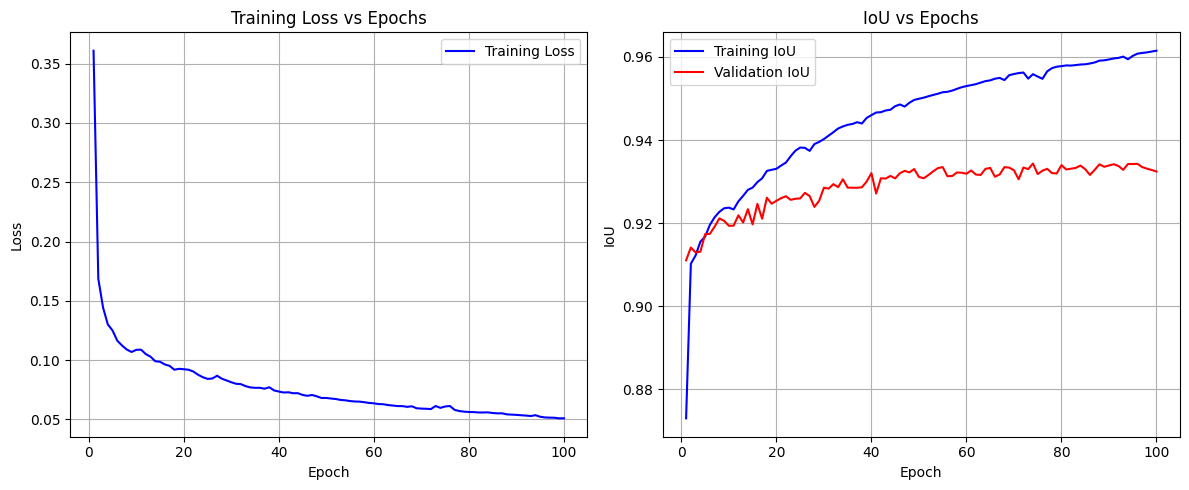

Evaluating on test set...


<ipython-input-9-d4dce278e670>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.1060, Test IoU: 0.9338


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Dataset paths
    image_dir = '/content/huron-dataset/Sliced_Images'
    mask_dir = '/content/huron-dataset/Sliced_masks'
    #labels_file = '/content/mapped_results_final.xlsx'

    # Transform for input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])


    # Create full dataset
    full_dataset = HuronDataset(image_dir, mask_dir, transform=transform)

    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

    # Model configuration
    encoder_name = "efficientnet-b4"

    # Initialize U-Net model
    model = smp.UnetPlusPlus(
        encoder_name=encoder_name,        # try different encoders
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights
        in_channels=3,                  # model input channels
        classes=1                      # model output channels
    ).to(device)


    # Initialize loss and optimizer
    criterion = CombinedLoss(
        smp.losses.DiceLoss(mode='binary'),
        nn.BCEWithLogitsLoss())
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0)

    print(f"Model: U-Net++ with {encoder_name} encoder and AdamW Optimizer")

    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100)

    # Evaluate on test set
    print("Evaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_iou = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

if __name__ == '__main__':
    main()